#CH7
###Reconocimiento de Expresiones Faciales con CNN y Fine-tuning

Dataset: https://www.kaggle.com/datasets/msambare/fer2013/code


###Introducción

El dataset empleado [1] se basa en una serie de imágenes, cada una de 48x48 pixeles en una escala de blanco y negro. Las cuales presentan 7 diferentes expresiones faciales (categorías) clasificadas de la siguiente manera:

*   0 = Angry
*   1 = Disgusto
*   2 = Miedo
*   3 = Feliz
*   4 = Tristeza
*   5 = Sorpresa
*   6 = Neutral

La data de entrenamiento contiene 28 709 imágenes y; para el test, 3589.

En general, para la clasificación de imágenes se necesita de dos enlaces principales: extraer las características de la imagen y entrenar los clasificadores.

Sin embargo, los métodos tradicionales de clasificación de imágenes basadas en el método de aprendizaje automático, presentan desventajas claras como limitación de la expresión de características, dificultad en la caracterización integral y el pobre efecto de clasificación. Ante ello, el uso de redes neuronales de aprendizaje profundo supervisado emerge como una alternativa eficaz de solución por la posibilidad de obtener características de las imágenes de forma automática y lograr la clasificación [2]. Pero en específico, esto se logra gracias al uso de **redes neuronales convolucionales (CNN)**, con la cual es posible obtener elevados rendimientos de clasificación; además porque simplifica el proceso mencionado al inicio, es decir, combina la extracción y clasificación en una red única de inicio a fin [3]. Como ejemplo, un método basado en las CCN utilizado en [4] para la clasificación de imágenes de un conjunto de datos de ImageNet, obtuvo un 97.8% de precisión, reduciendo significativamente el error.

###Metodología

La presente metodología pretende emplear redes neuronales convolucionales (CNN) para clasificación de imágenes, donde el modelo emplea 6 capas convolucionales, 1 capa densa, y 1 output layer que permite clasificarlo en 7 categorías.

**Descargando el dataset** de "kagglehub"


In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [12]:
# Directorios de "train" y "test"

train_dir = f"{path}/train"
test_dir = f"{path}/test"

Implementando **Data Generator** y **Data Augmentation**

Dado que la cantidad de datos disponible en problemas de clasificación de imágenes es limita, especialmente en sectores como salud o procesamiento de lenguaje natural [5], se implementó la técnica de **Data Augmentation** durante preprocesamiento. Consiste en generar versiones modificadas de las imágenes originales, aplicando transformaciones de traslación, horizontal flip, zoom y ajustes de brillo, con el objetivo de aumentar la diversidad de los datos de entrenamiento [6], reduciendo el riesgo de overfitting.

También se empleó el método *ImageDataGenerator* de Keras apra aplicar transformaciones en tiempo real.

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    rescale = 1./255,
    validation_split = 0.2
    )

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
    )

In [14]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts to grayscale
    class_mode = "categorical",      # Classifies into 7 categories
    subset = "training"
)

test_generator = test_datagen.flow_from_directory(
    directory = test_dir,
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts to grayscale
    class_mode = "categorical",      # Classifies into 7 categories
    subset = "validation"
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


Generación del **modelo**

In [15]:
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization

En esta sección se definen las **6 capas convolucionales** donde se emplean *kernels* de tamaño de 3x3, *padding*, función de activación *Relu*, *maxpooling2D*, y *dropout*. Por último, *softmax* por ser idóneo en categorización.

Se define la secuencia de la siguiente forma:

*   Input layer que representa el conjunto de datos FER2013, el cual contiene imágenes en escala de grises de 48×48 píxeles
*   6 capas convolucionales organizadas que contienen capas Conv2D con activación ReLU, seguidas de una capa MaxPooling2D y Dropout(0.25) para prevenir el sobreajuste.
*   1 capa de flattening, que transforma la salida 2D de los mapas de activación en un vector 1D
*   1 capa densa oculta (Dense) con activación ReLU, seguida de un Dropout(0.5)
*   1 capa de salida (Dense) con activación softmax, que permite la clasificación en las 7 categorías



In [16]:
model = Sequential()

# Convolutional layers (6)

## Input layer
model.add(Conv2D(filters = 32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(48,48,1)))

model.add(Conv2D(filters = 64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

## Flaten layer
model.add(Flatten())

## Fully connected layer
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

## Output layer -> 7 categorías
model.add(Dense(7, activation='softmax'))

**Compilación** de modelo generado

El modelo fue compilado con el optimizador **Adam**, usando como función de pérdida la categorical *crossentropy*, adecuada para clasificación multiclase.

In [17]:
from tensorflow.keras.optimizers import Adam

optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = optimiser,
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,248,071 (8.58 MB)

 Trainable params: 2,248,071 (8.58 MB)

 Non-trainable params: 0 (0.00 B)

**Entrenamiento** del modelo

Se entrenó 1ro con 100 épocas, pero por costo computacional y resultados, se emplearon 70 épocas con batch size de 64, usando el conjunto de prueba extraído del set de entrenamiento.

In [18]:
epochs = 70
batch_size = 64

history = model.fit(x = train_generator, epochs = epochs, validation_data = test_generator)

Epoch 1/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 114ms/step - accuracy: 0.2419 - loss: 1.8438 - val_accuracy: 0.2472 - val_loss: 1.8477
Epoch 2/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.2513 - loss: 1.8205 - val_accuracy: 0.2472 - val_loss: 1.8292
Epoch 3/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.2424 - loss: 1.8074 - val_accuracy: 0.2472 - val_loss: 1.8137
Epoch 4/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - accuracy: 0.2459 - loss: 1.7908 - val_accuracy: 0.2535 - val_loss: 1.7784
Epoch 5/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - accuracy: 0.2641 - loss: 1.7690 - val_accuracy: 0.3024 - val_loss: 1.7033
Epoch 6/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.2953 - loss: 1.7161 - val_accuracy: 0.3708 - val_loss: 1.6572
Epoch 7/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.3265 - loss: 1.6779 - val_accuracy: 0.4099 - val_loss: 1.5644
Epoch 8/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.3607 - loss: 1.6178 -

###Resultados

In [19]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Ploteamos dos gráficas de: **Accuracy & Loss**

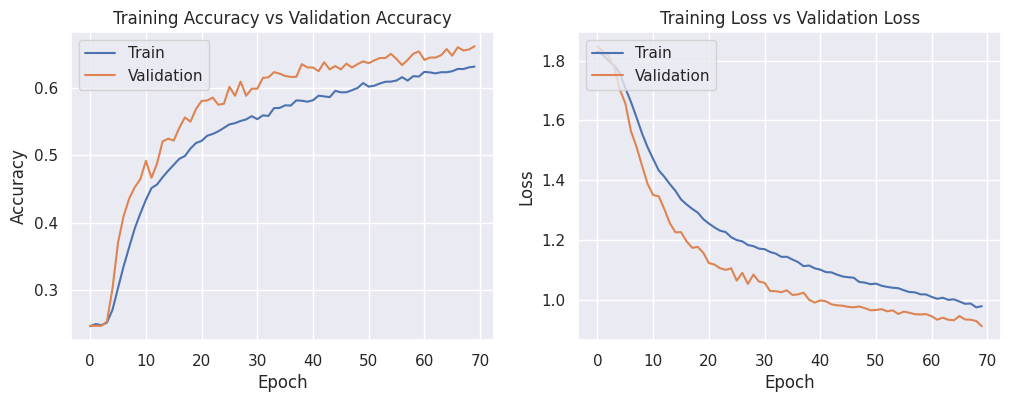

In [28]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [21]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.6734 - loss: 0.8690
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6594 - loss: 0.8921
final train accuracy = 67.69 , validation accuracy = 66.13


In [23]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Predecir para obtener las etiquetas predicted y true del test set
validation_labels = test_generator.classes
validation_pred_probs = model.predict(test_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


Graficamos **matriz de confusión** para observar las predicciones y diferencias

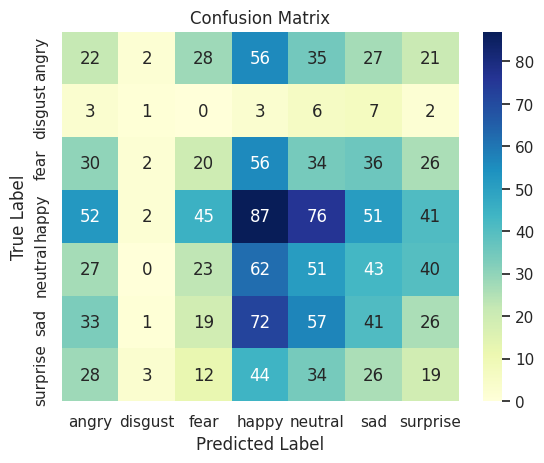

In [24]:
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())

sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Discusión

La arquitectura utilizada se diseñó para balancear la capacidad de aprendizaje con la **eficiencia computacional**. El uso de múltiples bloques convolucionales permite una extracción jerárquica de características, mientras que el *Dropout* evita el sobreajuste. La capa densa final resume la información para la toma de decisión. La función de pérdida *categorical_crossentropy* demostró ser adecuada, dada la naturaleza multiclase del problema, y los resultados obtenidos confirman que la arquitectura fue suficiente para capturar patrones faciales representativos sin caer en overfitting.

El modelo entrenado alcanzó un **accuracy** de **67.69% en conjunto de entrenamiento (train) y 66.13% en el conjunto de prueba (test)**. Además, se aprecia a partir de la función de pérdida o **loss** que el modelo fue capaz de aprender los patrones relevantes del dataset y **generalizarlos** al reducirse conforme las épocas aumentan, e indica que no hubo evidencia significativa de sobreajuste (overfitting) ni subajuste (underfitting) durante el entrenamiento.

En estudios como [7], emplea un algoritmo de CNN en tiempo real con la biblioteca OpenCV, basado en Raspberry Pi, reportó resultados de **65.97%** de accuracy. Otro estudio más reciente [8], desarrolló modelos que permitan reconocer emociones y expresiones faciales para que puedan proyectarse en un avatar en tiempo real dentro de cascos de realidad virtual. Con el fin de esta innovadora aplicación, uno de sus tres modelos alcanza una precisión del **63.0%**, con una desviación estándar de ±0.005.


De igual forma, el trabajo de [9] explora diversas técnicas de deep learning con un enfoque en CNN. Dentro de su revisión de la literatura, se destaca que más de 15 trabajos estudiaron este dataset, y reportaron valores de entre **57.4% a 87.13%**, evaluando diversos algoritmos CNN en estos últimos 5 años.

Por tanto, los resultados obtenidos en este trabajo se encuentran dentro de los rangos esperados y son coherentes con la literatura especializada. Cabe destacar que la arquitectura empleada en este estudio es de complejidad moderada, lo que la hace adecuada para aplicaciones en tiempo real o entornos con recursos computacionales limitados.

###Bibliografia

[1] Manas Sambare, “FER-2013,” Kaggle.com, 2020. Available: https://www.kaggle.com/datasets/msambare/fer2013/suggestions. [Accessed: Jun. 07, 2025]

[2] Li, D., Qiu, X., Zhu, Z., & Liu, Y. (2018). Criminal Investigation Image Classification Based on Spatial CNN Features and ELM. 2018 10th International Conference on Intelligent Human-Machine Systems and Cybernetics (IHMSC), 294–298. https://doi.org/10.1109/ihmsc.2018.10173

[3] Pei, Y., Huang, Y., Zou, Q., Zhang, X., & Wang, S. (2019). Effects of Image Degradation and Degradation Removal to CNN-Based Image Classification. IEEE Transactions on Pattern Analysis and Machine Intelligence, 43(4), 1239–1253. https://doi.org/10.1109/tpami.2019.2950923

[4] Hu, J., Shen, L., & Sun, G. (2018). Squeeze-and-Excitation Networks. ArXiv (Cornell University). https://doi.org/10.1109/cvpr.2018.00745

[5] Kim, W., Yeo, K. M., Jeong, W. C., Park, S. H., Park, J. D., & Moon, Y. B. (2024). Masked Background and Object Image Based Data Augmentation Method. 2022 13th International Conference on Information and Communication Technology Convergence (ICTC), 1329–1331. https://doi.org/10.1109/ictc62082.2024.10827114

[6] Wada, S., & Morimoto, N. (2024). Investigating Relationship between Data Augmentation Intensity and Model Performance in Natural Language Processing. 445–446. https://doi.org/10.1109/icce-taiwan62264.2024.10674562

[7] L. Zahara, P. Musa, E. P. Wibowo, I. Karim, and S. B. Musa, “The Facial Emotion Recognition (FER-2013) Dataset for Prediction System of Micro-Expressions Face Using the Convolutional Neural Network (CNN) Algorithm based Raspberry Pi,” 2020 Fifth International Conference on Informatics and Computing (ICIC), pp. 1–9, Nov. 2020, doi: https://doi.org/10.1109/icic50835.2020.9288560.

[8] A. Ortiz, S. C. Tamayo, D. Nunes, and Geovana Amorim Abensur, “Models for Real-Time Emotion Classification: FER-2013 Dataset,” Lecture notes in networks and systems, pp. 289–304, Jan. 2024, doi: https://doi.org/10.1007/978-3-031-66431-1_19.‌

‌[9] N. Yalçin and M. Alisawi, “Introducing a novel dataset for facial emotion recognition and demonstrating significant enhancements in deep learning performance through pre-processing techniques,” Heliyon, vol. 10, no. 20, p. e38913, Oct. 2024, doi: https://doi.org/10.1016/j.heliyon.2024.e38913.
‌
